In [1]:
import numpy as np # We'll be storing our data as numpy arrays
import os # For handling directories
from PIL import Image # For handling the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Plotting

In [2]:
import tensorflow as tf
import cv2
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import math
import numpy as np
import pandas as pd
import time
from sklearn.svm import SVC
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [4]:
filname = 'fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df_svm=pd.read_csv('fer2013.csv')

In [5]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [6]:
df_svm.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [7]:
#Input and Output Data
X = df_svm.pixels.apply(lambda x: np.array(x.split(' ')).astype('float32'))
X = np.stack(X, axis=0)
Y = np.array(df_svm['emotion'])

In [8]:
X.shape

(35887, 2304)

In [9]:
Y.shape

(35887,)

In [10]:
#Preprocessing
#Face Alignment

In [10]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [11]:
def face_align(gray):
  sz = gray.shape
  # Creating variable eyes
  eyes = eye_cascade.detectMultiScale(gray, 1.3, 5)
  if len(eyes) > 1 :
    index=0
    # Creating for loop in order to divide one eye from another
    for (ex , ey,  ew,  eh) in eyes:
      if index == 0:
        eye_1 = (ex, ey, ew, eh)
      elif index == 1:
        eye_2 = (ex, ey, ew, eh)
      index += 1
    if eye_1[0] < eye_2[0]:
      left_eye = eye_1
      right_eye = eye_2
    else:
      left_eye = eye_2
      right_eye = eye_1
        
    # Calculating coordinates of a central points of the rectangles
    left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
    left_eye_x = left_eye_center[0] 
    left_eye_y = left_eye_center[1]
        
    right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
    right_eye_x = right_eye_center[0]
    right_eye_y = right_eye_center[1]

    if left_eye_y > right_eye_y:
      A = (right_eye_x, left_eye_y)
      # Integer -1 indicates that the image will rotate in the clockwise direction
      direction = -1 
    else:
      A = (left_eye_x, right_eye_y)
      # Integer 1 indicates that image will rotate in the counter clockwise direction
      direction = 1 
        
    delta_x = right_eye_x - left_eye_x
    delta_y = right_eye_y - left_eye_y
    angle=np.arctan(delta_y/delta_x)
    angle = (angle * 180) / np.pi

    # Width and height of the image
    h, w = gray.shape[:2]
    # Calculating a center point of the image
    # Integer division "//"" ensures that we receive whole numbers
    center = (w // 2, h // 2)
    # Defining a matrix M and calling
    # cv2.getRotationMatrix2D method
    M = cv2.getRotationMatrix2D(center, (angle), 1.0)
    # Applying the rotation to our image using the
    # cv2.warpAffine method
    gray = cv2.warpAffine(gray, M, (w, h))

    #Again detecting face
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces) > 0 : 
      (x,y,w,h) = faces[0]
      gray = gray[y:y+h, x:x+w]

  gray = cv2.resize(gray,sz) 
  return gray

In [12]:
X_new = []
for j in range(X.shape[0]):
  px = np.array(X[j]).reshape(48,48)
  px = np.array(px, dtype='uint8')
  px = face_align(px)
  X_new.append(np.array(px).reshape(48*48))
X = np.array(X_new)

In [13]:
# Plot confusion matrix 

import seaborn as sns
import matplotlib.pyplot as plt

def create_confmat(true_labels, predicted_labels, columns, colour = 'Greens', size = (20,14)):
    sns.set(font_scale=1.5)
    cm = confusion_matrix(true_labels, predicted_labels) 
    cm_df = pd.DataFrame(cm,
    index = [col for col in columns], 
    columns = [col for col in columns])
    plt.figure(figsize=(18,16))
    sns.heatmap(cm_df, annot = True, cmap = colour, fmt='g', linewidths=.2)
    plt.title('Confusion Matrix', fontsize = 20)
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y,
                                                    shuffle=True, stratify=Y,
                                                    test_size=0.2, random_state=2)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((28709, 2304), (7178, 2304), (28709,), (7178,))

In [15]:
#PCA to retain 95% variation and reduce dataset size
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32))
X_valid = scaler.transform(X_valid.astype(np.float32))
pca = PCA(n_components=.95)
pca.fit(X_train)
X_test_p = pca.transform(X_valid)
X_train_p = pca.transform(X_train)
scaler = StandardScaler()
X_train_p = scaler.fit_transform(X_train_p.astype(np.float32))
X_test_p = scaler.transform(X_test_p.astype(np.float32))
X_train_p.shape ,X_test_p.shape 

((28709, 269), (7178, 269))

In [16]:
#Using rbf kernel¶
model = SVC(kernel ='rbf')
model.fit(X_train_p, y_train)
model.score(X_test_p , y_valid)

0.4605739760378936

In [18]:
y_pred=model.predict(X_test_p)
#print(y_pred)

In [19]:
print(y_pred)

[0 3 0 ... 3 5 6]


In [20]:
random_state = 0
epochs = 10000
kernel = 'rbf'  # 'rbf', 'linear', 'poly' or 'sigmoid'
decision_function = 'ovr'  # 'ovo' for OneVsOne and 'ovr' for OneVsRest'
   
svm_model = SVC(random_state=random_state, max_iter=epochs, kernel=kernel, decision_function_shape=decision_function)
svm_model.fit(X_train_p, y_train)

c:\users\tv\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(max_iter=10000, random_state=0)

In [21]:
svm_model.score(X_test_p , y_valid)


0.4605739760378936

In [109]:
y_pred=svm_model.predict(X_test_p) 

In [110]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [111]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [112]:
len(y_pred)

7178

In [113]:
X.shape

(35887, 2304)

In [117]:
x_im = X_valid.reshape(7178,48,48)
x_im.shape[0]

7178

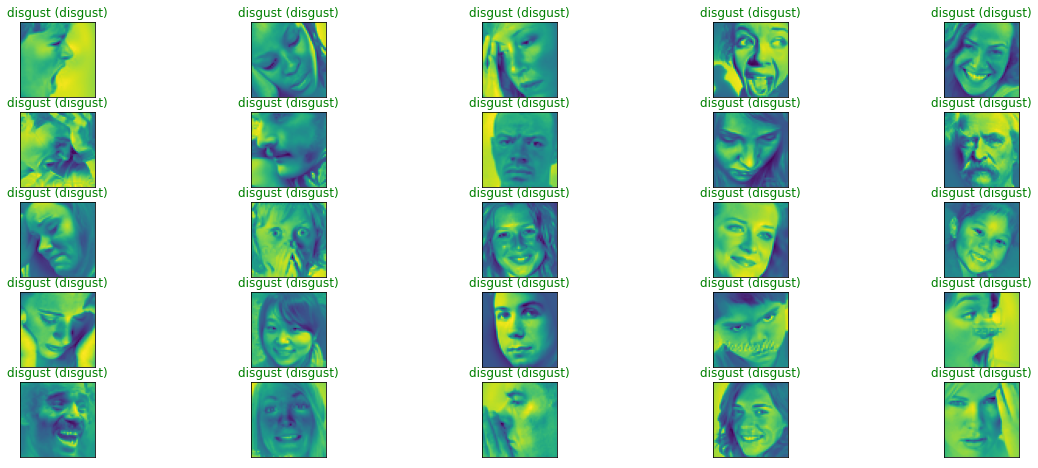

In [121]:
labelsFaces =['disgust', 'anger', 'sadness', 'surprise', 'contempt', 'fear', 'happy']

#y_pred=y_pred.reshape(269,269)
#predictedExpression = svm_model.predict(y_pred)

figure = plt.figure(figsize=(20, 8))

for i, index in enumerate(np.random.choice(x_im.shape[0], size=25, replace=False)):
    ax = figure.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_im[index]))
    predict_index = np.argmax(y_pred[index])
    true_index = np.argmax(Y[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labelsFaces[predict_index], 
                                  labelsFaces[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()


In [29]:
from PIL import Image, ImageOps

In [59]:
happy_image = Image.open("happy.jpeg")

In [32]:
happy_image.show()

In [60]:
gray_happy_image = ImageOps.grayscale(happy_image)
gray_happy_image.show()

In [61]:
gray_happy_image_resized = gray_happy_image.resize((48, 48))
gray_happy_image_resized.show()

In [62]:
print(len(np.array(gray_happy_image_resized)))

48


In [63]:
np.array(gray_happy_image_resized)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 154, 254, 255],
       [255, 255, 239, ..., 115, 244, 255],
       [255, 255, 194, ..., 109, 234, 255]], dtype=uint8)

In [64]:
gray_happy_image_resized.save('External_Images/gray_happy_image_resized.jpeg')

In [51]:
img = Image.open('External_Images/gray_happy_image_resized.jpeg')
arr = np.array(img)
print(arr.shape)
flat_arr = arr.ravel()
print(flat_arr)

(48, 48)
[255 255 255 ... 103 240 251]


In [58]:
group_image = Image.open("External_Images/group.jpeg")
gray_group_image = ImageOps.grayscale(group_image)
gray_group_image_resized = gray_group_image.resize((48, 48))
gray_group_image_resized.save('External_Images/gray_group_image_resized.jpeg')

In [65]:
img_group = Image.open('External_Images/gray_group_image_resized.jpeg')
arr_group = np.array(img_group)
print(arr_group.shape)
flat_arr_group = arr_group.ravel()
print(flat_arr_group)

(48, 48)
[ 6 24 15 ... 14  1  3]


In [70]:
import pandas as pd
DF = pd.DataFrame(flat_arr_group)
DF.to_csv("data2.csv")

In [71]:
df_svm_ext=pd.read_csv('ext_dat.csv')

In [90]:
X_ext = df_svm_ext.pixels.apply(lambda x: np.array(x.split(' ')).astype('float32'))
X_ext = np.stack(X_ext, axis=0)
X_ext.shape

(2, 2304)

In [ ]:
#PCA to retain 95% variation and reduce dataset size
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32))
X_valid = scaler.transform(X_valid.astype(np.float32))
pca = PCA(n_components=.95)
pca.fit(X_train)
X_test_p = pca.transform(X_valid)
X_train_p = pca.transform(X_train)
scaler = StandardScaler()
X_train_p = scaler.fit_transform(X_train_p.astype(np.float32))
X_test_p = scaler.transform(X_test_p.astype(np.float32))
X_train_p.shape ,X_test_p.shape 

In [108]:
scaler = StandardScaler()
X_ext = scaler.fit_transform(X_ext.astype(np.float32))
pca = PCA(n_components=269)
pca.fit(X_ext)
X_ext_p = pca.transform(X_ext)
scaler = StandardScaler()
X_ext_p.shape
#X_ext_p = scaler.fit_transform(X_ext_p.astype(np.float32))
#X_ext_p = scaler.transform(X_ext_p.astype(np.float32))
#X_ext_p.shape

ValueError: n_components=269 must be between 0 and min(n_samples, n_features)=2 with svd_solver='full'